In [315]:
from __future__ import absolute_import, division, print_function

import os
import ast
#import urllib, cStringIO

import pymongo as pm

import numpy as np
import scipy.stats as stats
import pandas as pd
import json
import re

from PIL import Image
import base64
import sys

import matplotlib
from matplotlib import pylab, mlab, pyplot
%matplotlib inline
from IPython.core.pylabtools import figsize, getfigs
plt = pyplot
import seaborn as sns
sns.set_context('talk')
sns.set_style('white')

import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)
warnings.filterwarnings("ignore", message="numpy.dtype size changed")
warnings.filterwarnings("ignore", message="numpy.ufunc size changed")

In [316]:
# directory & file hierarchy
proj_dir = os.path.abspath('../../..')
analysis_dir = os.getcwd()
results_dir = os.path.join(proj_dir,'results')
plot_dir = os.path.join(results_dir,'plots')
csv_dir = os.path.join(results_dir,'csv')
exp_dir = os.path.abspath(os.path.join(proj_dir,'experiments'))
sketch_dir = os.path.abspath(os.path.join(proj_dir,'sketches'))

## add helpers to python path
if os.path.join(proj_dir,'analysis','python') not in sys.path:
    sys.path.append(os.path.join(proj_dir,'analysis','python'))
    
if not os.path.exists(results_dir):
    os.makedirs(results_dir)
    
if not os.path.exists(plot_dir):
    os.makedirs(plot_dir)   
    
if not os.path.exists(csv_dir):
    os.makedirs(csv_dir)       
    
# Assign variables within imported analysis helpers
import analysis_helpers as h
if sys.version_info[0]>=3:
    from importlib import reload
reload(h)

<module 'analysis_helpers' from '/Users/megumisano/graphical_conventions/analysis/python/analysis_helpers.pyc'>

### load sketch features + metadata

In [317]:
reload(h)
cropping = 'no_crop'
base_path = '../../../data/features/'
path_to_feats = base_path + '{}/FEATURES_FC6_sketch.npy'.format(cropping)
path_to_meta = base_path + '{}/METADATA_sketch.csv'.format(cropping)
path_to_feats_stroke_analysis = base_path + 'FEATURES_FC6_sketch_stroke_analysis.npy'
path_to_meta_stroke_analysis = base_path + 'METADATA_sketch_stroke_analysis.csv'

F = np.load(path_to_feats)
F_stroke_analysis = np.load(path_to_feats_stroke_analysis)
cors = np.corrcoef(F)
triu_inds = np.triu_indices(cors.shape[0], k = 1)
assert np.round(np.mean(cors[triu_inds]),2) != 1, 'F has redundant rows'

M = h.clean_up_metadata(pd.read_csv(path_to_meta))
M_ = h.clean_up_metadata(pd.read_csv(path_to_meta_stroke_analysis))
assert F.shape[0]==M.shape[0], 'F and M are different sizes'

In [95]:
png_dir = os.path.join(sketch_dir, 'stroke_analysis/png')
png_paths = os.listdir(png_dir)
for path in png_paths:
    trial_level_path = path.split('/')[-1]
    if trial_level_path!= '.DS_Store':
        if int(trial_level_path.split('_')[1]) > 40:
            print(trial_level_path)

In [318]:
M_stroke_analysis = pd.DataFrame()
gameID_list = []
trialNum_list = []
condition_list = []
target_list = []
repetition_list = []
numStrokesDeleted_list = []
directions_list = []
feature_ind_list = []
for i,d in M_.iterrows():
    label = d['label'].split('_')
    gameID_list.append(label[0])
    trialNum_list.append(label[1])
    condition_list.append(label[2])
    target_list.append(label[3])
    repetition_list.append(label[4])
    numStrokesDeleted_list.append(label[5])
    directions_list.append(label[6])
    feature_ind_list.append(d['feature_ind'])
M_stroke_analysis['gameID'] = gameID_list 
M_stroke_analysis['trial_num'] = trialNum_list 
M_stroke_analysis['condition'] = condition_list 
M_stroke_analysis['target'] = target_list 
M_stroke_analysis['repetition'] = repetition_list
M_stroke_analysis['num_strokes_deleted'] = numStrokesDeleted_list
M_stroke_analysis['direction'] = directions_list 
M_stroke_analysis['feature_ind'] = feature_ind_list

## core analyses

### 1. Between-sketch similarity analyses 

##### Within-pair convergence 
- RDM, with each cell representing dissimilarity between the sketches of two repetition numbers, averaged within target and within gameID 
- Plot similarity between sketches of `base_rep` and `base_rep + 1` against `base_rep`; shows how similarity of sketches between adjacent repetitions changes with increasing repetition

/Users/megumisano/anaconda/envs/py27/lib/python2.7/site-packages/pandas/core/frame.py:6211: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort)


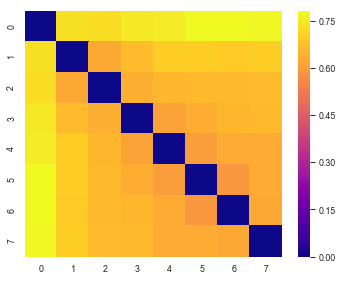

In [4]:
# create matrix for similarity between repetitions averaged within target and within game
arr_of_corrmats = h.make_adjacency_matrix(M, F, 'gameID')

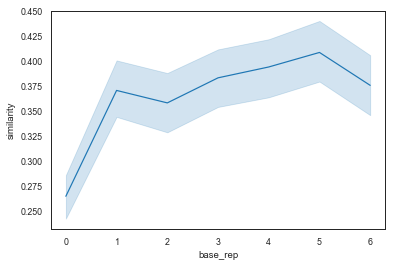

In [5]:
# plot within-pair convergence
h.plot_within_interaction_similarity(arr_of_corrmats)

##### Within-pair baseline
- For baseline, sketches are permuted across gameIDs 
- RDM, with each cell representing dissimilarity between the sketches of two repetition numbers, averaged within target and within gameID 
- Plot similarity between sketches of `base_rep` and `base_rep + 1` against `base_rep`; shows how similarity of sketches between adjacent repetitions changes with increasing repetition

/Users/megumisano/graphical_conventions/analysis/python/analysis_helpers.py:837: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  M_targ_rep['pseudo_gameID'] = list(gameIDs)


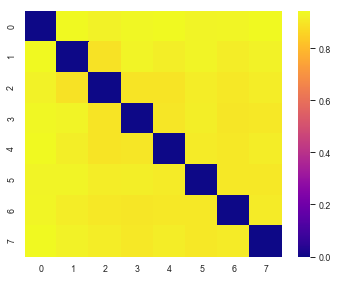

In [6]:
reload(h)
# permute across gameIDs
M_permuted_gameID = h.scramble_df_across_gameID_within_target_and_rep(M)
# create matrix for similarity between adjacent repetitions averaged within target and within game (PERMUTED)
arr_of_corrmats_permuted = h.make_adjacency_matrix(M_permuted_gameID, F, 'pseudo_gameID')

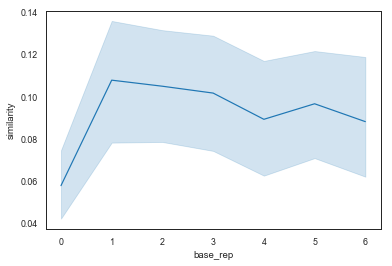

In [7]:
# plot within-pair convergence (PERMUTED)
h.plot_within_interaction_similarity(arr_of_corrmats_permuted)

##### Between-pair convergence
- Plot similarity between sketches of different gameIDs within target and within repetition 

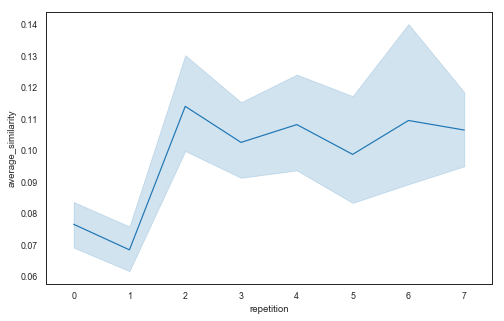

In [8]:
# plot between-pair divergence 
reload(h)
h.plot_between_interaction_similarity(M, F, 'repetition')

##### Between-pair baseline
- For baseline, sketches are permuted across repetition, but within-target and within-pair structure are preserved 

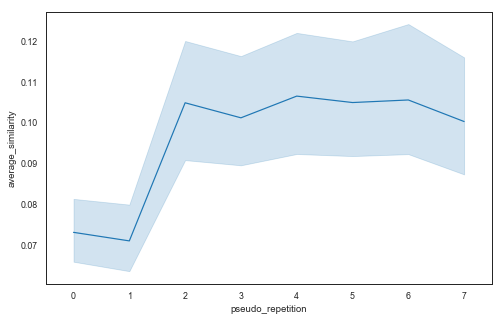

In [9]:
reload(h)
# permute across repetition 
M_permuted_rep = h.scramble_df_across_repetition_within_target_and_gameID(M)
# plot between-pair divergence (PERMUTED))
h.plot_between_interaction_similarity(M_permuted_rep, F, 'pseudo_repetition')

### 2. Within- sketch analyses 

##### First vs final stroke priority (Temporal stroke structure)
- For any pair of successive sketches, we compute baseline similarity, and see how similarity changes as we delete strokes from either the later or the earlier sketch, either in the forward or reverse direction 
- Plot similarity timecourse across stroke deletions (similarity is normalized so that baseline similarity is 1.0 and number of strokes deleted is normalized to be percentage of strokes deleted)
- Superimpose first-deleted and final-deleted to see whether it hurrts similarity more to remove from start or to remove from end 

In [467]:
reload(h)
D = pd.read_csv(os.path.join(results_dir, 'graphical_conventions.csv'))
# create dataframe for stroke analysis
stroke_analysis_df = h.get_stroke_analysis_df(D, M_stroke_analysis, F_stroke_analysis)

##### Plotting for each repetition pair e.g. rep0 and rep1, rep1 and rep2, etc. (continous)

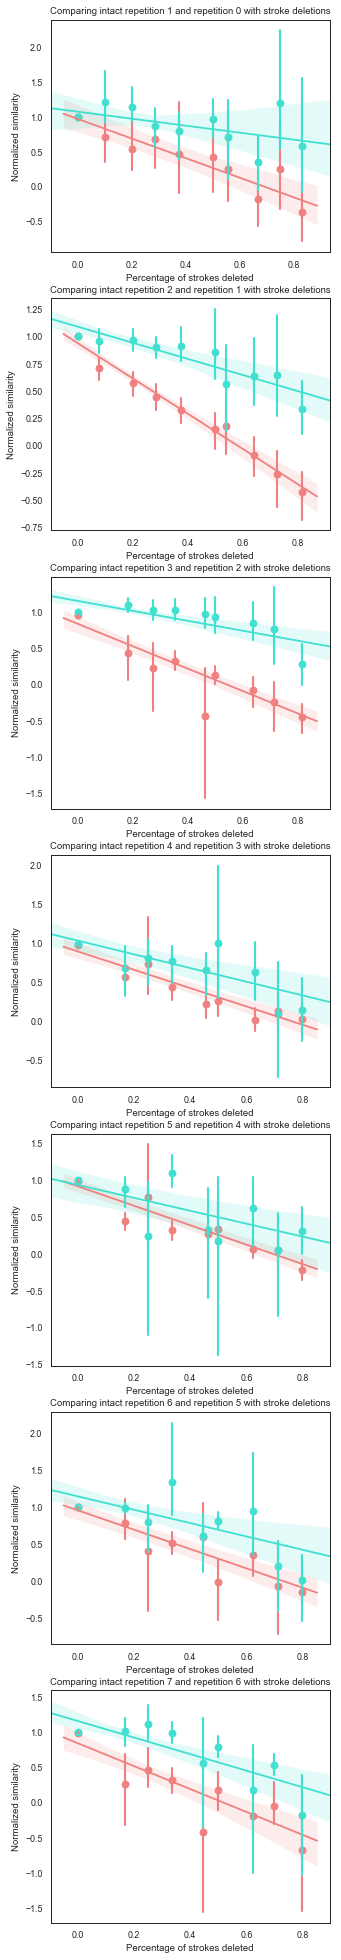

In [454]:
reload(h)
# lesion earlier sketch 
sns.set_context("paper")
fig, axs = plt.subplots(nrows=7, figsize=(5,35))
h.plot_stroke_similarity_rep_specific(stroke_analysis_df, False, axs)

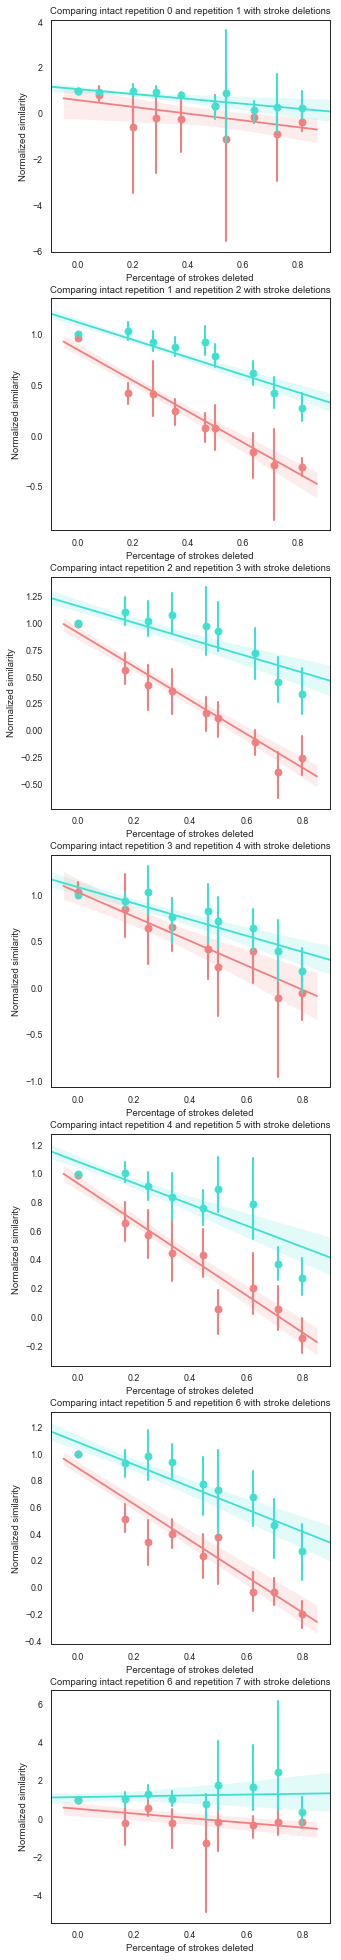

In [455]:
# lesion later sketch 
sns.set_context("paper")
fig, axs = plt.subplots(nrows=7, figsize=(5,35))
h.plot_stroke_similarity_rep_specific(stroke_analysis_df,True, axs)

##### Aggregating across repetition pairs (continuous)

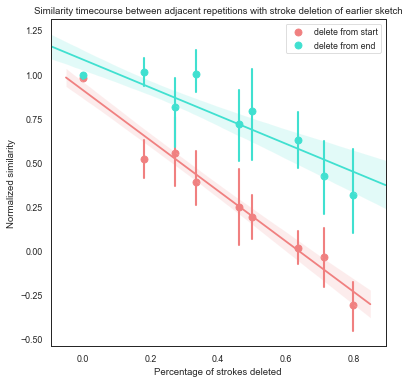

In [461]:
# lesion earlier sketch 
reload(h)
sns.set_context("paper")
fig, ax = plt.subplots(figsize=(6, 6))
h.plot_stroke_similarity_rep_aggregate(stroke_analysis_df, False, ax)

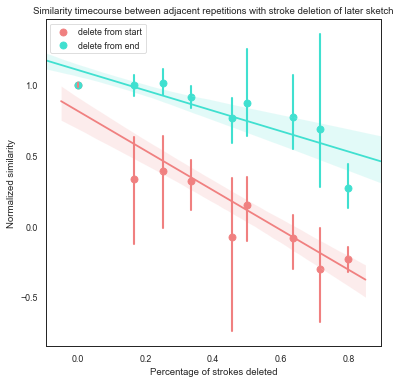

In [462]:
# lesion later sketch 
reload(h)
sns.set_context("paper")
fig, ax = plt.subplots(figsize=(6, 6))
h.plot_stroke_similarity_rep_aggregate(stroke_analysis_df, True, ax)

##### With facets corresponding to total number of strokes in sketch (discrete)

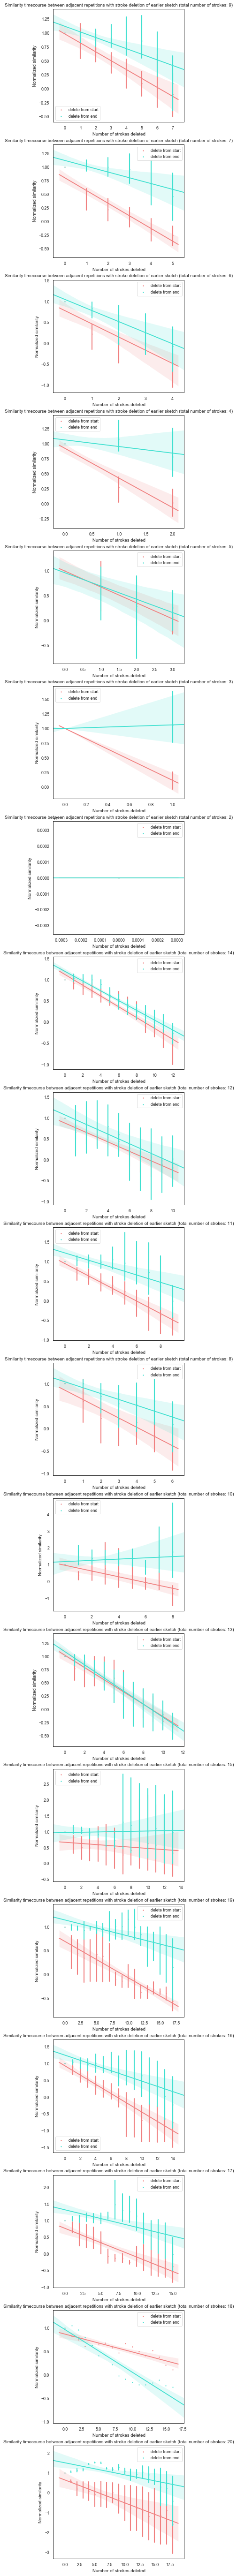

In [490]:
sns.set_context("paper")
h.plot_stroke_similarity_discrete(stroke_analysis_df, False)

##### Fine-grained properties of individual sketches 

In [21]:
### sensitivity analysis (i.e. heat map tracing)

In [22]:
### similarity of part-level features across reps 

In [480]:
stroke_analysis_df

,gameID,target,percentage_strokes_deleted,num_strokes_deleted,total_num_strokes,similarity,base_rep,direction,lesion_later_sketch
0,0050-769c4742-aefc-4bea-aeb2-7dc48b51fe82,dining07,0.000000,0,9,1.000000,0,start,True
0,0050-769c4742-aefc-4bea-aeb2-7dc48b51fe82,dining07,0.111111,1,9,-0.074212,0,start,True
0,0050-769c4742-aefc-4bea-aeb2-7dc48b51fe82,dining07,0.222222,2,9,-0.024347,0,start,True
0,0050-769c4742-aefc-4bea-aeb2-7dc48b51fe82,dining07,0.333333,3,9,0.100845,0,start,True
0,0050-769c4742-aefc-4bea-aeb2-7dc48b51fe82,dining07,0.444444,4,9,-0.697601,0,start,True
0,0050-769c4742-aefc-4bea-aeb2-7dc48b51fe82,dining07,0.555556,5,9,-0.805992,0,start,True
0,0050-769c4742-aefc-4bea-aeb2-7dc48b51fe82,dining07,0.666667,6,9,-0.648169,0,start,True
0,0050-769c4742-aefc-4bea-aeb2-7dc48b51fe82,dining07,0.777778,7,9,-0.999389,0,start,True
0,0050-769c4742-aefc-4bea-aeb2-7dc48b51fe82,dining00,0.000000,0,7,1.000000,0,start,True
0,0050-769c4742-aefc-4bea-aeb2-7dc48b51fe82,dining00,0.142857,1,7,0.789092,0,start,True


## supplementary analyses

In [68]:
# plotting 8 RDMs, one for each repetition 
fig, axs = plt.subplots(2, 4, sharex=True, sharey=True, figsize=(40,20))
for rep in range(8): 
    x_ind = rep % 4
    y_ind = 0 if rep < 4 else 1 
    M_rep = M[M['repetition'] == str(int(rep))]
    M_rep_sorted = M_rep.sort_values(by=['target'])
    sorted_feature_ind = list(M_rep_sorted['feature_ind'])
    get_and_plot_RDM(M_rep, F, sorted_feature_ind, axs, x_ind, y_ind, rep)

saving sketches from game: 7053-d1f771d6-a55b-4681-961f-5a9ebb43cbdb
saving sketches from game: 3558-8fa206a2-9b8c-4d67-a4ab-0832dc0d0f25
saving sketches from game: 6964-d6de9966-f3dd-45df-8d24-d5bfd5d46eb8
saving sketches from game: 4853-a05bfdd7-095c-4b93-bdde-2b99fd29c7a2
saving sketches from game: 5616-7114c020-0e81-482c-952b-b26fc66076a0
saving sketches from game: 9817-6f2a66db-fc24-482d-aa20-1980ad6f524e
saving sketches from game: 7527-5ab8c64c-3f95-4864-bb6a-f9cad4b0d34e
saving sketches from game: 1820-86afdf51-4b4c-43a9-a9e1-e6e20618de1b
saving sketches from game: 7438-c77fa69e-d41c-41a4-b530-fc2809c07323
saving sketches from game: 9075-d6c9b0a6-bfb2-4148-ae19-d0da518aef97
saving sketches from game: 7637-26870e81-faae-4521-a2e9-10424526a22c
saving sketches from game: 4395-6cdb78e3-0c3f-4526-9670-8e4c1dcbc542
saving sketches from game: 3480-03933bf3-5e7e-4ecd-b151-7ae57e6ae826
saving sketches from game: 7360-1ccf92da-d46d-4315-8c81-6620388ee62f
saving sketches from game: 8103-96

##### path-dependence

In [ ]:
def get_corr_coefs(M,F):
    auto_corr_df = pd.DataFrame()
    for g in list(M['gameID'].unique()):
        for t in list(M[M['gameID'] == g]['target'].unique()):
            mini_df = M[(M['gameID'] == g) & (M['target'] == t)] 
            #mini_df = M[(M['gameID'] == '0050-769c4742-aefc-4bea-aeb2-7dc48b51fe82') & (M['target'] == 'dining_05')] 
            for base_rep in mini_df['repetition'].unique():
                base_ind = list(mini_df[mini_df['repetition'] == base_rep]['feature_ind'])[0]
                for other_rep in mini_df['repetition'].unique():
                    if base_rep < other_rep:# check if other_rep is bigger - only compare forward 
                        rep_dist = other_rep - base_rep
                        other_ind = list(mini_df[mini_df['repetition'] == other_rep]['feature_ind'])[0]
                        features_to_compare = F[[base_ind, other_ind], :]
                        corr_coef = np.corrcoef(features_to_compare)[1][0]
                        df_to_add = pd.DataFrame([[g, t, base_rep,  rep_dist, corr_coef]], columns=['gameID', 'target', 'base_rep', 'rep_dist', 'corr_coef'])
                        auto_corr_df = auto_corr_df.append(df_to_add)
    return auto_corr_df

auto_corr_df = get_corr_coefs(M, F)

In [ ]:
# how does the similarity between sketches of adjacent repetitions change with increasing base repetition number? 
sns.regplot(
    data=auto_corr_df,
    x_estimator=np.mean,
    x='base_rep',
    y='corr_coef',
    logx=True)

In [ ]:
# how does the similarity between sketches of adjacent repetitions change with increasing repetition distance? 
sns.regplot(
    data=auto_corr_df,
    x_estimator=np.mean,
    x='rep_dist',
    y='corr_coef')

In [ ]:
new_df_ = pd.DataFrame()
for rep in auto_corr_df['base_rep'].unique():
    df_ = auto_corr_df[auto_corr_df['base_rep'] == rep]
    for dist in df_['rep_dist'].unique():
        _df = df_[df_['rep_dist'] == dist]
        mean = np.mean(np.array(_df['corr_coef']))
        df_to_add = pd.DataFrame([[rep, dist, mean]], columns=['base_rep', 'rep_dist', 'mean_corr_coef'])
        new_df_ = new_df_.append(df_to_add)

In [ ]:
g = sns.FacetGrid(data=new_df_, col="rep_dist", height=3, aspect=1, col_wrap=4, margin_titles=True)
g = g.map(plt.scatter, "base_rep", "mean_corr_coef")
# g = sns.catplot(x="base_rep", y="mean_corr_coef",
#                 col="rep_dist", data=new_df_,col_wrap=2)

##### classifier approach

In [ ]:
#sklearn
from sklearn import decomposition, ensemble
from sklearn.model_selection import train_test_split
from sklearn.metrics  import accuracy_score
from sklearn.svm import LinearSVC
from sklearn.datasets import make_classification
from sklearn.linear_model import LogisticRegression
from sklearn.calibration import CalibratedClassifierCV

In [ ]:
# make dataframe with just the first repetition 
M_0 = M[M['repetition'] == 0]
y = list(M_0['target'])
feature_inds = list(M_0['feature_ind'])
features = F[feature_inds, :]
x = pd.DataFrame(features)

X_train_0, X_test_0, y_train_0, y_test_0 = train_test_split(x, y, test_size = 0.2)

# make dataframe with just the last repetition 
M_7 = M[M['repetition'] == 7]
y = list(M_7['target'])
feature_inds = list(M_7['feature_ind'])
features = F[feature_inds, :]
x = pd.DataFrame(features)

X_train_7, X_test_7, y_train_7, y_test_7 = train_test_split(x, y, test_size = 0.2)

In [ ]:
# makes training and testing sets for sketches from specific repetition 
def make_sets(M, rep):
    # make dataframe with just the last repetition 
    M_= M[M['repetition'] == rep]
    y = list(M_['target'])
    feature_inds = list(M_['feature_ind'])
    features = F[feature_inds, :]
    x = pd.DataFrame(features)
    return train_test_split(x, y, test_size = 0.2)

In [ ]:
# make either training set or testing set (all sketches used for either one of them)
def get_x_and_y(M, rep):
    M_= M[M['repetition'] == rep]
    y = list(M_['target'])
    feature_inds = list(M_['feature_ind'])
    features = F[feature_inds, :]
    x = pd.DataFrame(features)
    return x, y

In [ ]:
def classify_sketches(train_rep, test_rep):
    summary_df = pd.DataFrame()
    for i in range(1):
    
        # first train on the train_rep sketches
        X_train_, y_train_= get_x_and_y(M, train_rep)
        logreg = LogisticRegression(multi_class='multinomial', solver='newton-cg')
        #clf = CalibratedClassifierCV(log) 
        logreg.fit(X_train_, y_train_)
#         svc = LinearSVC(random_state=0)
#         clf = CalibratedClassifierCV(svc) 
#         clf.fit(X_train_, y_train_)

        # for each repetition, predict from features, record accuracy and class probability    
        for rep in test_rep:
            X_test, y_test = get_x_and_y(M, rep)
            y_pred = logreg.predict(X_test)
            acc = accuracy_score(y_test, y_pred)
            prob = logreg.predict_proba(X_test)
            prob_df_svc = pd.DataFrame(prob)
            prob_df_svc.columns=list(logreg.classes_)
            prob_df_svc['target'] = y_test
            prob_list = []
            prob_df_svc = prob_df_svc.reset_index(drop=True)
            for j, d in prob_df_svc.iterrows():
                target = d['target']
                class_prob = d[target]
                prob_list.append(class_prob)
            mean_prob = np.mean(prob_list)

            df_to_add = pd.DataFrame([[i, rep, acc, mean_prob]], columns=['iteration','test_rep', 'accuracy', 'class_prob'])
            summary_df = summary_df.append(df_to_add)

    return summary_df

In [ ]:
summary_df0 = classify_sketches(0, [1,7])
summary_df7 = classify_sketches(7, [6,0])
summary_df0['train_rep'] = [0] * summary_df0.shape[0]
summary_df7['train_rep'] = [7] * summary_df7.shape[0]
summary_df_list = [summary_df0, summary_df7]
combined_df = pd.concat(summary_df_list, axis=0)
combined_df = combined_df.reset_index(drop=True)
distance_list = []
for i,d in combined_df.iterrows():
    distance_list.append(abs(d['test_rep']-d['train_rep']))
combined_df['distance'] = distance_list
combined_df = combined_df.reset_index(drop=True)

In [ ]:
sns.set_context("paper")
plt.figure(figsize=(5,5))
sns.pointplot(
    data=combined_df,
    x='distance',
    y='accuracy',
    hue='train_rep',
    palette="Set1")

In [ ]:
def get_x_and_y_permute(M, rep):
    M_= M[M['pseudo_repetition'] == rep]
    y = list(M_['target'])
    feature_inds = list(M_['feature_ind'])
    features = F[feature_inds, :]
    x = pd.DataFrame(features)
    return x, y

In [ ]:
def classify_sketches_permute(train_rep, test_rep):
    summary_df = pd.DataFrame()
    
    # first train on the train_rep sketches
    X_train_, y_train_= get_x_and_y_permute(M, train_rep)
    logreg = LogisticRegression(multi_class='multinomial', solver='newton-cg')
    #clf = CalibratedClassifierCV(log) 
    logreg.fit(X_train_, y_train_)
#         svc = LinearSVC(random_state=0)
#         clf = CalibratedClassifierCV(svc) 
#         clf.fit(X_train_, y_train_)

    # for each repetition, predict from features, record accuracy and class probability    
    for rep in test_rep:
        X_test, y_test = get_x_and_y_permute(M, rep)
        y_pred = logreg.predict(X_test)
        acc = accuracy_score(y_test, y_pred) # temporarily just do accuracy 
#         prob = logreg.predict_proba(X_test)
#         prob_df_svc = pd.DataFrame(prob)
#         prob_df_svc.columns=list(logreg.classes_)
#         prob_df_svc['target'] = y_test
#         prob_list = []
#         prob_df_svc = prob_df_svc.reset_index(drop=True)
#         for j, d in prob_df_svc.iterrows():
#             target = d['target']
#             class_prob = d[target]
#             prob_list.append(class_prob)
        mean_prob = 1#np.mean(prob_list)

        df_to_add = pd.DataFrame([[i, rep, acc, mean_prob]], columns=['iteration','test_rep', 'accuracy', 'class_prob'])
        summary_df = summary_df.append(df_to_add)

    return summary_df

In [ ]:
final_combined_df_permute = pd.DataFrame()
random_seed = 4000000000
for i in range(1000):
    if i % 100 == 0:
        print (str(i) + "th iteration")
    pseudo_rep_list = []
    for g in list(M['gameID'].unique()):
        for t in list(M[M['gameID'] == g]['target'].unique()):
            mini_df = M[(M['gameID'] == g) & (M['target'] == t)] 
            rep_list = np.array(mini_df['repetition'])
            # pass in different random seed for each one 
            np.random.seed(random_seed)
            shuffled_rep_list = np.random.permutation(rep_list)
            pseudo_rep_list = pseudo_rep_list + list(shuffled_rep_list)
            random_seed = random_seed - 1
    M['pseudo_repetition'] = pseudo_rep_list
    summary_df0 = classify_sketches_permute(0, [1,7])
    summary_df7 = classify_sketches_permute(7, [6,0])
    summary_df0['train_rep'] = [0] * summary_df0.shape[0]
    summary_df7['train_rep'] = [7] * summary_df7.shape[0]
    summary_df_list = [summary_df0, summary_df7]
    combined_df_permute = pd.concat(summary_df_list, axis=0)
    combined_df_permute = combined_df_permute.reset_index(drop=True)
    distance_list = []
    for j,d in combined_df_permute.iterrows():
        distance_list.append(abs(d['test_rep']-d['train_rep']))
    combined_df_permute['distance'] = distance_list
    combined_df_permute = combined_df_permute.reset_index(drop=True)
    final_combined_df_permute = final_combined_df_permute.append(combined_df_permute)#add(combined_df_permute, fill_value=0)
result = final_combined_df_permute / 1000

In [ ]:
sns.set_context("paper")
plt.figure(figsize=(5,5))
g = sns.pointplot(
    data=final_combined_df_permute,
    x='distance',
    y='accuracy',
    hue='train_rep',
    palette="Set1")
g.set(ylim=(0.5, 0.6))

In [ ]:
sns.set_context("paper")
plt.figure(figsize=(5,5))
sns.pointplot(
    data=final_combined_df_permute,
    x='distance',
    y='accuracy',
    hue='train_rep',
    palette="Set1")

##### bootstrap

In [ ]:
# make either training set or testing set (all sketches used for either one of them)
from sklearn.metrics import log_loss
def get_x_and_y(M, rep):
    M_= M[M['repetition'] == rep]
    y = list(M_['target'])
    feature_inds = list(M_['feature_ind'])
    features = F[feature_inds, :]
    x = pd.DataFrame(features)
    return x, y

def get_training_set_error(train_rep):
    X_train, y_train = get_x_and_y(M, train_rep)
    targets = pd.Series(y_train).unique()
    logreg = LogisticRegression(multi_class='multinomial', solver='newton-cg')
    logreg.fit(X_train, y_train)
    #y_pred = logreg.predict(X_test)
    y_pred = logreg.predict_proba(X_train)
    # train classifier on these sample sketches from repetition (train) and test on sketches from game g repetition (test)
    classification_loss = log_loss(y_train, y_pred, labels=targets)
    return classification_loss

In [ ]:
games = list(M['gameID'].unique())
#targets = list(M['target'].unique())
number_of_games = len(games)

bootstrap_samples = []
for i in range(1000):
    sample = np.random.choice(number_of_games, number_of_games)
    bootstrap_samples.append(sample)
    
def get_error(train_rep, test_rep):
    
    #grand_total_classification_loss = 0
    err_df = pd.DataFrame()
    for g in games:
        print("computing average classification loss for game " + g + " with train rep: " + str(train_rep) + " and test rep: " + str(test_rep))

        samples_without_g = [sample for sample in bootstrap_samples if games.index(g) not in sample] 
        total_classification_loss = 0
        training_set_error = get_training_set_error(train_rep)
        sample_index=0
        for sample in samples_without_g:
            games_ = pd.Series(games)
            sample_games = games_[sample] # sample is just a list of indices, so get actual games 
            sample_games = list(sample_games)
            M_train = M[M['gameID'].isin(sample_games)]
            X_train, y_train = get_x_and_y(M_train, train_rep)
            targets = pd.Series(y_train).unique()
            M_test = M[M['gameID'] == g]
            X_test, y_test = get_x_and_y(M_test, test_rep)
            logreg = LogisticRegression(multi_class='multinomial', solver='newton-cg')
            logreg.fit(X_train, y_train)
            #y_pred = logreg.predict(X_test)
            y_pred = logreg.predict_proba(X_test)
            # train classifier on these sample sketches from repetition (train) and test on sketches from game g repetition (test)
            classification_loss = log_loss(y_test, y_pred, labels=targets)
            total_classification_loss = total_classification_loss + classification_loss
            sample_index=sample_index+1
        average_classification_loss = total_classification_loss / len(samples_without_g)
        error = 0.632 * average_classification_loss + 0.368 * training_set_error
        df_to_add = pd.DataFrame([[error, g, sample_index, train_rep, test_rep]], columns=['error', 'gameID', 'sample_index', 'train_rep', 'test_rep'])
        err_df = err_df.append(df_to_add)
        #grand_total_classification_loss = grand_total_classification_loss + average_classification_loss
    #grand_average_classification_loss = grand_total_classification_loss / len(games)

    #error_632 = 0.632 * grand_average_classification_loss + 0.368 * training_set_error 
    return err_df

# df_0_1 = get_error(0,1)
# df_0_1.to_csv("df_0_1.csv")
df_0_7 = get_error(0,7)
df_0_7.to_csv("df_0_7.csv")
df_7_6 = get_error(7,6)
df_7_6.to_csv("df_7_6.csv")
df_7_0 = get_error(7,0)
df_7_0.to_csv("df_7_0.csv")

In [ ]:
df_0_1 = pd.read_csv("df_0_1.csv")
all_err_df = pd.concat([df_0_1, df_0_7, df_7_6, df_7_0])
all_err_df.to_csv("all_err_df.csv")

In [ ]:
# convert to and add distance 
all_err_df = pd.read_csv("all_err_df.csv")
distance_list = []
for j,d in all_err_df.iterrows():
    distance_list.append(abs(d['test_rep']-d['train_rep']))
all_err_df['distance'] = distance_list

sns.set_context("paper")
plt.figure(figsize=(5,5))
sns.pointplot(
    data=all_err_df,
    x='distance',
    y='error',
    hue='train_rep',
    palette="Set1")